In [218]:
import pandas as pd
import numpy as np
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import seaborn as sb
import matplotlib.pyplot as plt
import math
from scipy import optimize
import time
import sys
sys.path.append('/Users/alenastern/Documents/Spring2018/Machine_Learning/Machine_Learning_Public_Policy/hws/hw2')
import numpy as np
import explore as ex
import preprocess as pp
import getfeatures as gf
import evalmodel as em
import trainmodel as tm
from __future__ import division
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read in Data

In [261]:
outcomes = ex.read_data("data/outcomes.csv")
projects = ex.read_data("data/projects.csv")

In [122]:
projects['date_posted'] = pd.to_datetime(projects['date_posted'])

In [123]:
# Drop all variables besides fully_funded (label) from outcomes to avoid leakage

outcomes = outcomes[['projectid', 'fully_funded']]

In [254]:
#Subset project data for projects posted between 2011-2013

X = projects[(projects['date_posted'].dt.year >= 2011) & (projects['date_posted'].dt.year <= 2013)]

In [255]:
#Subset outcomes data for incldued projects

Y = outcomes[outcomes['projectid'].isin(X['projectid'])]

In [256]:
total_data = pd.merge(X, Y, on = 'projectid')

In [260]:
total_data.columns

Index(['school_metro', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_prefix', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'fulfillment_labor_materials', 'total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached', 'eligible_double_your_impact_match', 'eligible_almost_home_match', 'date_posted', 'fully_funded'], dtype='object')

In [257]:
#Convert boolean variables from "t"/"f" to 1/0

colnames = ['fully_funded', 'school_charter', 'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp', 'school_charter_ready_promise', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow', 'eligible_double_your_impact_match', 'eligible_almost_home_match']
for col in colnames:
    
    mask = total_data[col] == 'f'
    column_name = col
    total_data.loc[mask, col] = 0
    
    mask = total_data[col] == 't'
    column_name = col
    total_data.loc[mask, col] = 1

In [258]:
#Drop variables that have information that will not be helpful for prediction, such as IDs and school geographic information

total_data = pp.drop_vars(total_data, ['teacher_acctid', 'schoolid', 
                          'school_ncesid', 'school_latitude', 'school_longitude', 'school_city', 'school_zip', 'school_district',
                          'school_county', 'projectid', 'school_state'])

# Explore Data

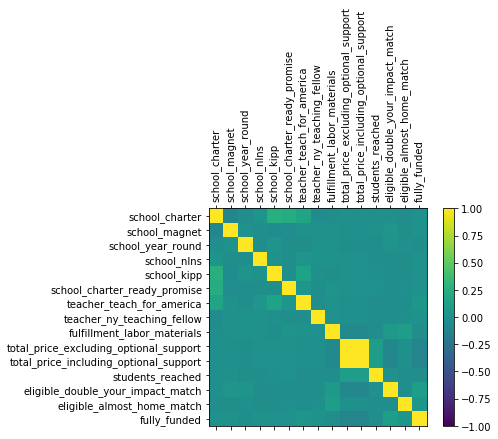

In [259]:
corr = ex.corr_table(total_data)
ex.plot_corr_matrix(corr)

In [273]:
total_data['month'] = total_data['date_posted'].dt.month

In [238]:
avg_month = total_data.groupby([total_data['date_posted'].dt.year, total_data['date_posted'].dt.month]).mean()

In [244]:
avg_month['date_posted'] = avg_month.index

/Users/alenastern/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


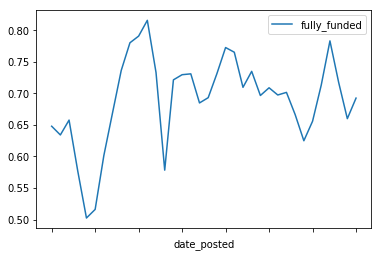

In [265]:
avg_month.plot(x='date_posted', y = ['fully_funded'], kind = 'line' )
plt.show()

/Users/alenastern/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


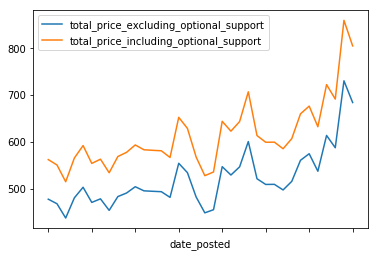

In [245]:
avg_month.plot(x='date_posted', y = ['total_price_excluding_optional_support', 'total_price_including_optional_support'], kind = 'line' )
plt.show()

/Users/alenastern/anaconda3/lib/python3.6/site-packages/pandas/plotting/_core.py:1716: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  series.name = label


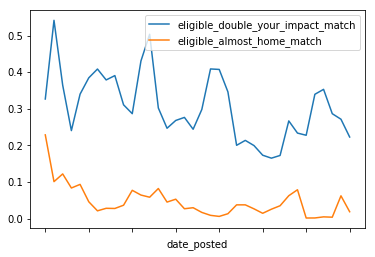

In [264]:
avg_month.plot(x='date_posted', y = ['eligible_double_your_impact_match', 'eligible_almost_home_match'], kind = 'line' )
plt.show()

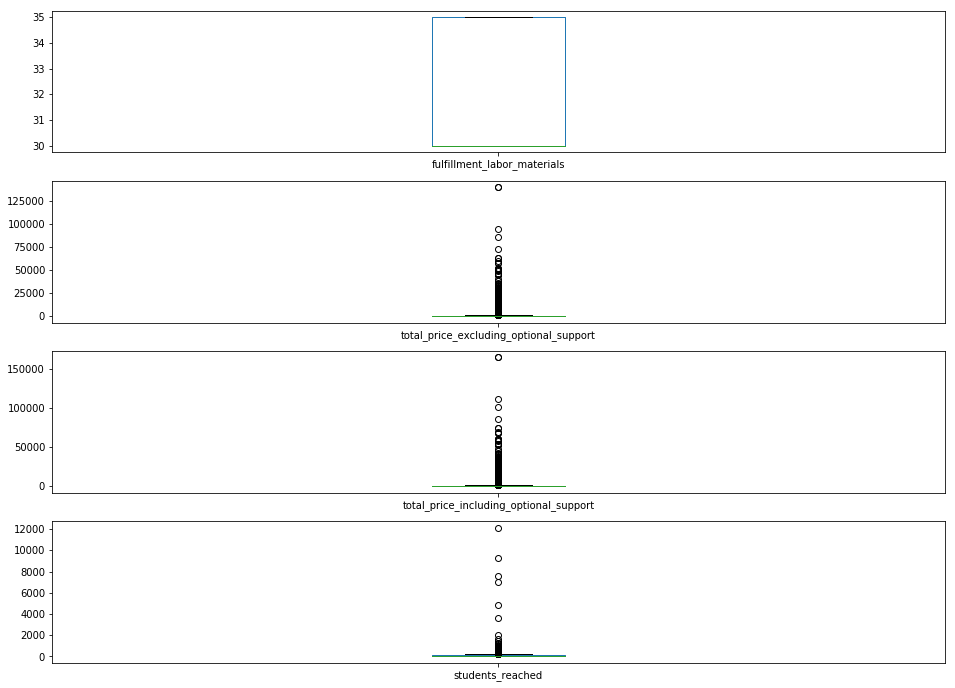

In [267]:
continuous_vars = ['fulfillment_labor_materials','total_price_excluding_optional_support', 
                   'total_price_including_optional_support', 'students_reached']

continuous_data = total_data[continuous_vars]

ex.outliers_plot(continuous_data)                                  
                                          

# Generate Features

In [ ]:
total_data = gf.cat_to_dummy(total_data, ['school_metro','month', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject','teacher_prefix',
                                          'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level', 'grade_level'])

In [268]:
bin_sep = total_data.students_reached.quantile([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

data, bins = gf.discretize(total_data, "students_reached", num_bins = bin_sep)
bins

array([1.0000e+00, 1.8000e+01, 2.1000e+01, 2.4000e+01, 2.6000e+01,
       3.1000e+01, 5.0000e+01, 7.5000e+01, 1.2000e+02, 2.0000e+02,
       1.2143e+04])

In [269]:
bin_sep = total_data.total_price_including_optional_support.quantile([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

data, bins = gf.discretize(total_data, "total_price_including_optional_support", num_bins = bin_sep)
bins

array([4.3560000e+01, 2.2691000e+02, 3.0022000e+02, 3.7556000e+02,
       4.4096000e+02, 5.0267000e+02, 5.5211000e+02, 6.3887000e+02,
       8.0161000e+02, 9.9609000e+02, 1.6438284e+05])

In [270]:
bin_sep = total_data.total_price_excluding_optional_support.quantile([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

data, bins = gf.discretize(total_data, "total_price_excluding_optional_support", num_bins = bin_sep)
bins

array([3.7030000e+01, 1.9287000e+02, 2.5519000e+02, 3.1923000e+02,
       3.7482000e+02, 4.2727000e+02, 4.6929000e+02, 5.4304000e+02,
       6.8137000e+02, 8.4668000e+02, 1.3972541e+05])

In [275]:
total_data = pp.drop_vars(total_data, ["students_reached", "total_price_including_optional_support","school_suburban", 'primary_focus_subject', 'month', 'primary_focus_area', 'secondary_focus_area',
                          'secondary_focus_subject', 'resource_type', 'poverty_level', "total_price_excluding_optional_support", 'grade_level', 'grade_level', 'teacher_prefix', 'school_metro'])



In [276]:
ex.dist_table(total_data)

,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,fulfillment_labor_materials,eligible_double_your_impact_match,eligible_almost_home_match,fully_funded,students_reached_bins,total_price_including_optional_support_bins,total_price_excluding_optional_support_bins,school_metro_rural,school_metro_suburban,school_metro_urban,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,primary_focus_subject_Applied Sciences,primary_focus_subject_Character Education,primary_focus_subject_Civics & Government,primary_focus_subject_College & Career Prep,primary_focus_subject_Community Service,primary_focus_subject_ESL,primary_focus_subject_Early Development,primary_focus_subject_Economics,primary_focus_subject_Environmental Science,primary_focus_subject_Extracurricular,primary_focus_subject_Foreign Languages,primary_focus_subject_Gym & Fitness,primary_focus_subject_Health & Life Science,primary_focus_subject_Health & Wellness,primary_focus_subject_History & Geography,primary_focus_subject_Literacy,primary_focus_subject_Literature & Writing,primary_focus_subject_Mathematics,primary_focus_subject_Music,primary_focus_subject_Nutrition,primary_focus_subject_Other,primary_focus_subject_Parent Involvement,primary_focus_subject_Performing Arts,primary_focus_subject_Social Sciences,primary_focus_subject_Special Needs,primary_focus_subject_Sports,primary_focus_subject_Visual Arts,primary_focus_area_Applied Learning,primary_focus_area_Health & Sports,primary_focus_area_History & Civics,primary_focus_area_Literacy & Language,primary_focus_area_Math & Science,primary_focus_area_Music & The Arts,primary_focus_area_Special Needs,secondary_focus_subject_Applied Sciences,secondary_focus_subject_Character Education,secondary_focus_subject_Civics & Government,secondary_focus_subject_College & Career Prep,secondary_focus_subject_Community Service,secondary_focus_subject_ESL,secondary_focus_subject_Early Development,secondary_focus_subject_Economics,secondary_focus_subject_Environmental Science,secondary_focus_subject_Extracurricular,secondary_focus_subject_Foreign Languages,secondary_focus_subject_Gym & Fitness,secondary_focus_subject_Health & Life Science,secondary_focus_subject_Health & Wellness,secondary_focus_subject_History & Geography,secondary_focus_subject_Literacy,secondary_focus_subject_Literature & Writing,secondary_focus_subject_Mathematics,secondary_focus_subject_Music,secondary_focus_subject_Nutrition,secondary_focus_subject_Other,secondary_focus_subject_Parent Involvement,secondary_focus_subject_Performing Arts,secondary_focus_subject_Social Sciences,secondary_focus_subject_Special Needs,secondary_focus_subject_Sports,secondary_focus_subject_Visual Arts,teacher_prefix_Dr.,teacher_prefix_Mr.,teacher_prefix_Mrs.,teacher_prefix_Ms.,secondary_focus_area_Applied Learning,secondary_focus_area_Health & Sports,secondary_focus_area_History & Civics,secondary_focus_area_Literacy & Language,secondary_focus_area_Math & Science,secondary_focus_area_Music & The Arts,secondary_focus_area_Special Needs,resource_type_Books,resource_type_Other,resource_type_Supplies,resource_type_Technology,resource_type_Trips,resource_type_Visitors,poverty_level_high poverty,poverty_level_highest poverty,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2
count,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353050.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.000000,353151.00

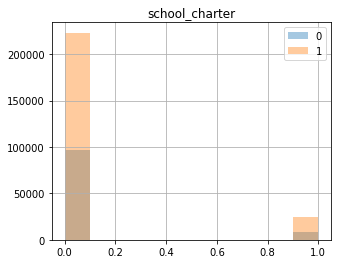

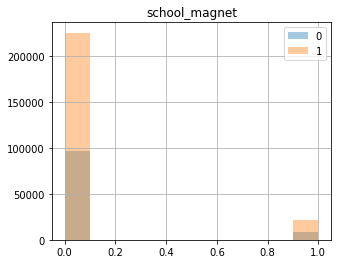

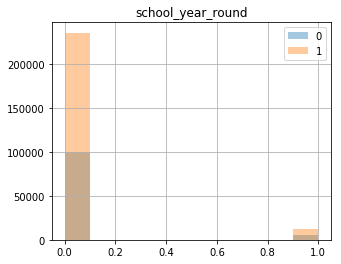

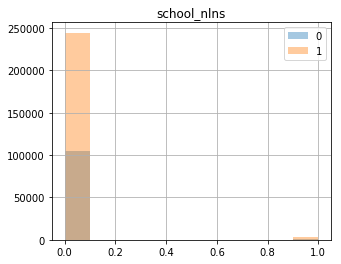

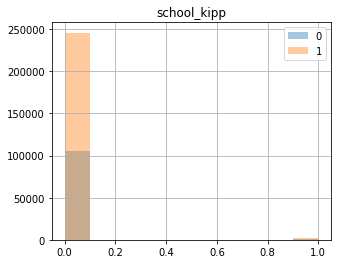

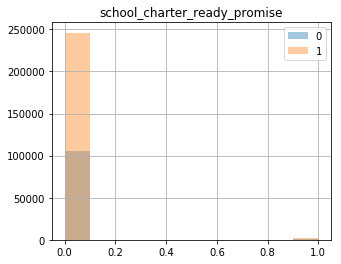

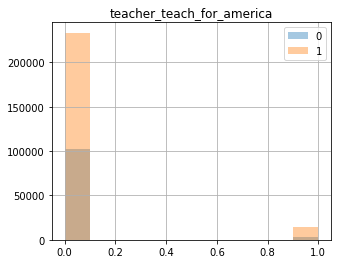

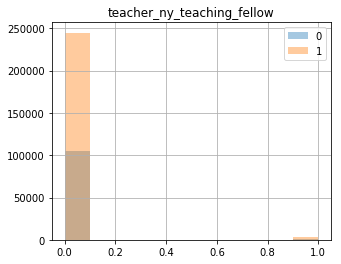

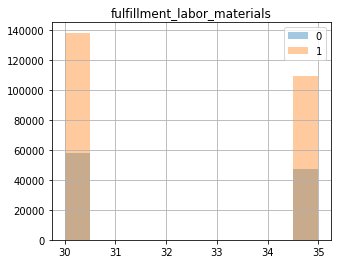

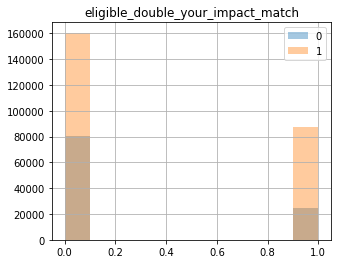

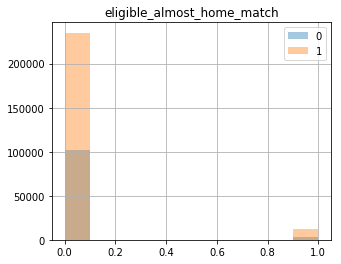

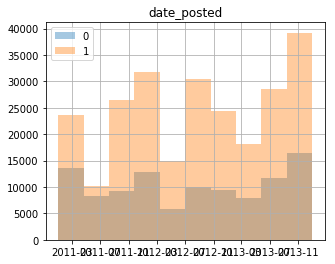

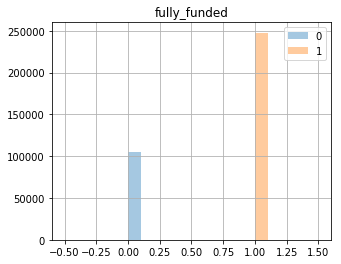

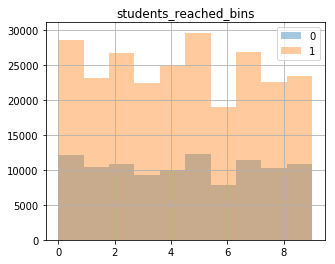

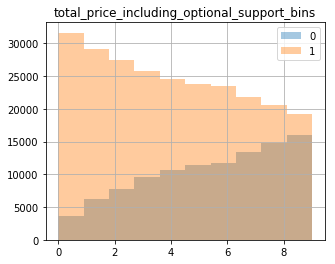

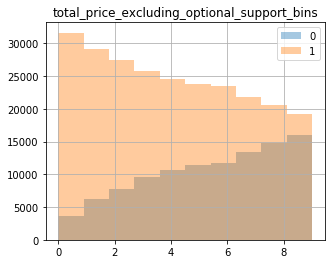

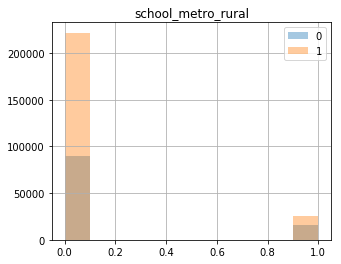

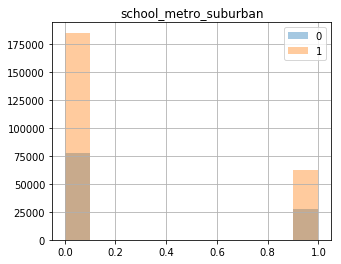

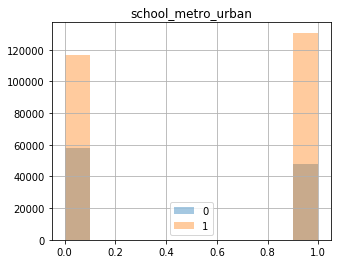

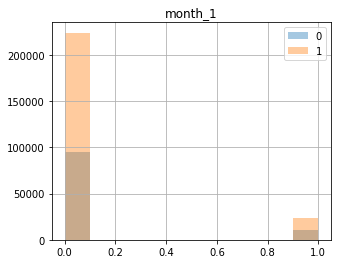

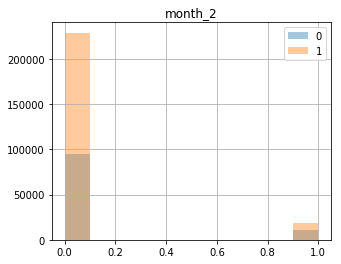

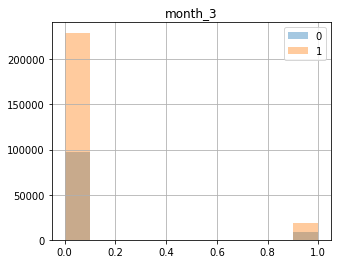

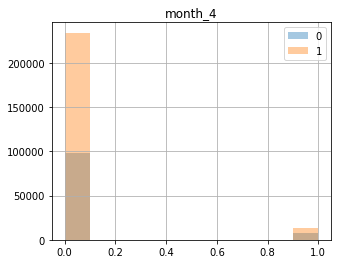

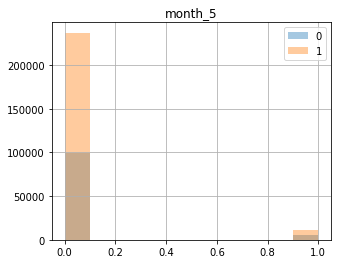

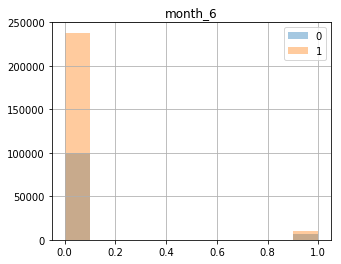

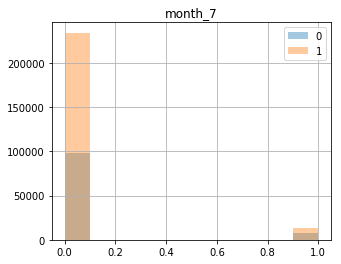

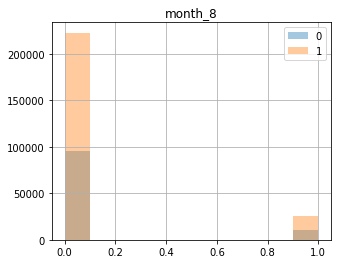

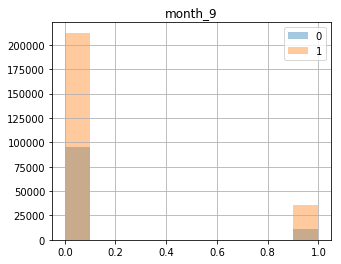

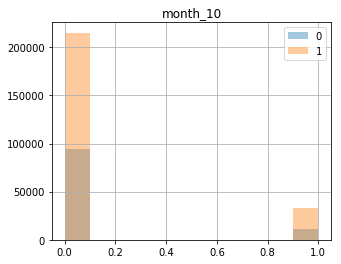

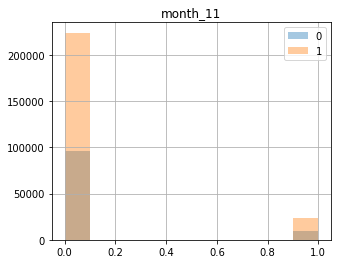

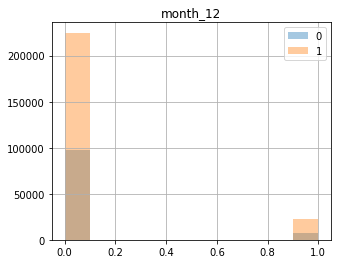

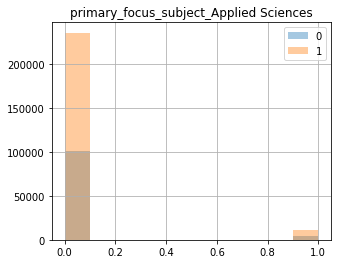

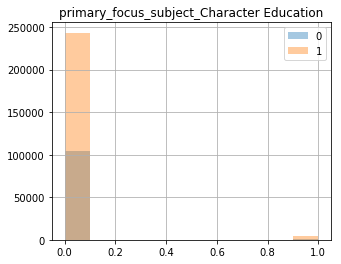

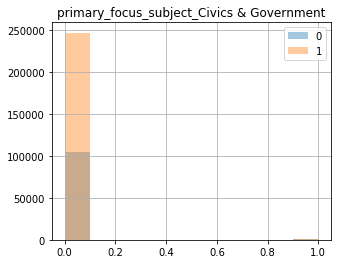

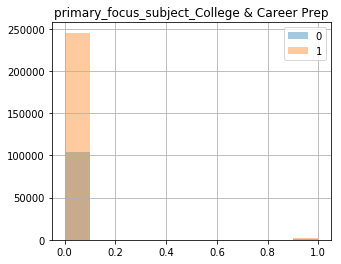

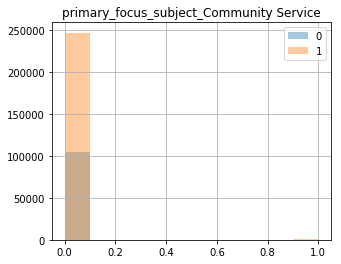

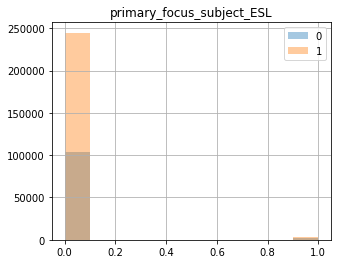

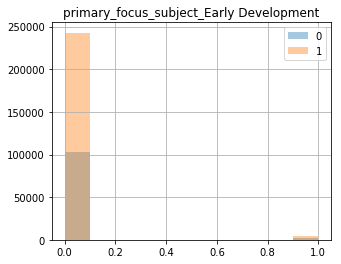

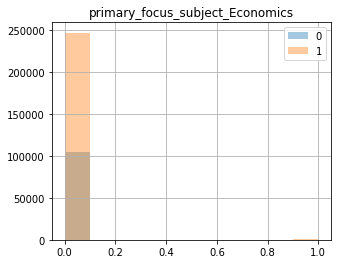

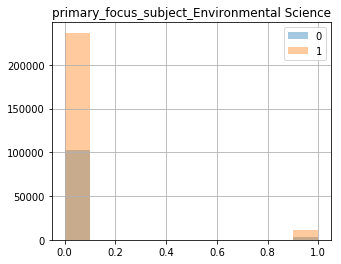

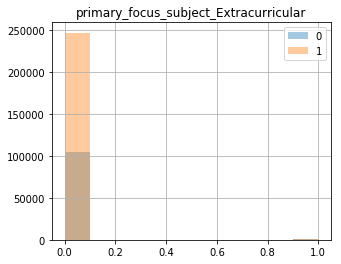

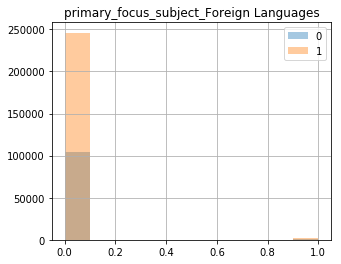

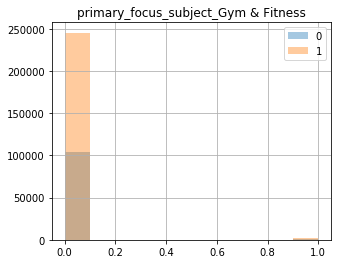

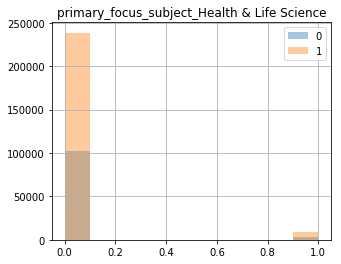

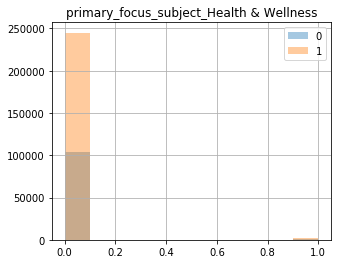

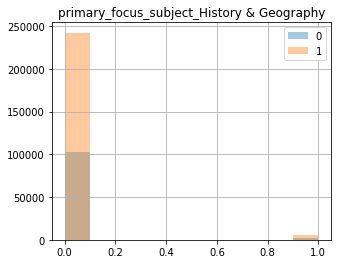

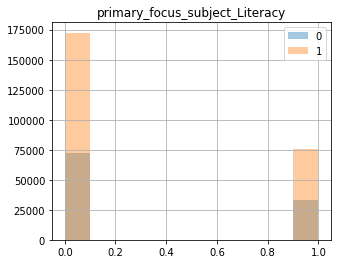

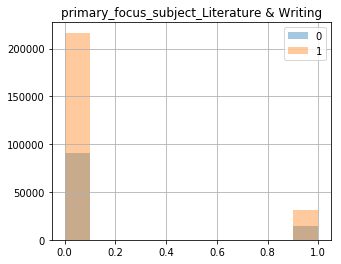

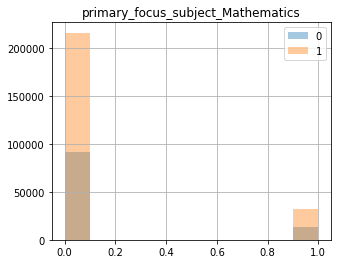

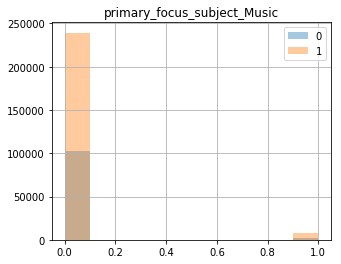

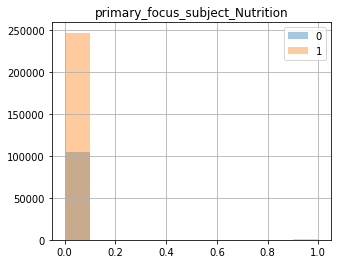

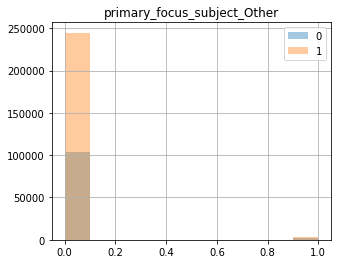

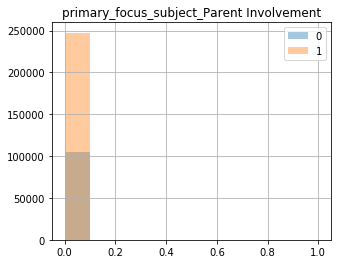

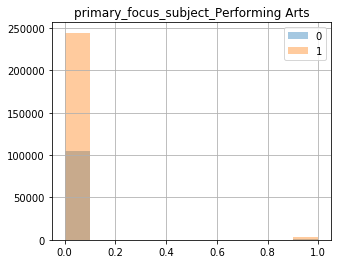

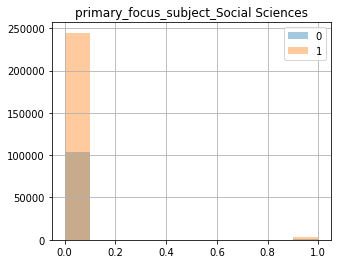

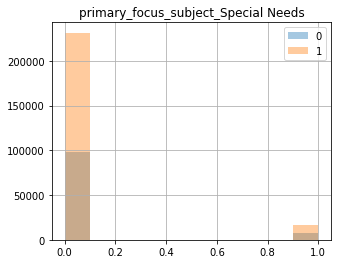

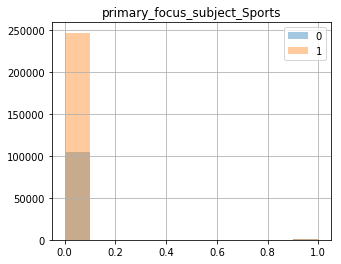

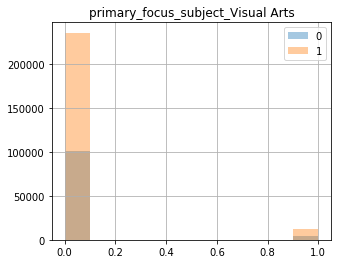

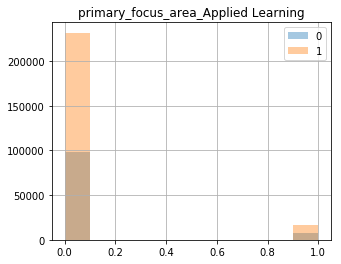

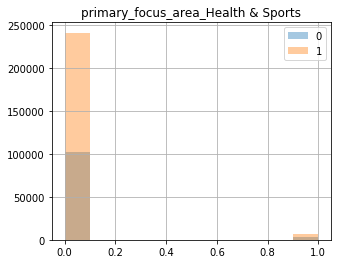

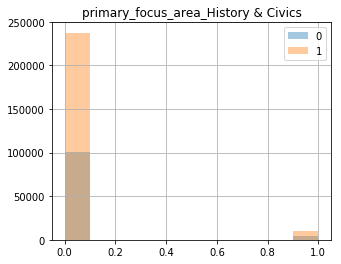

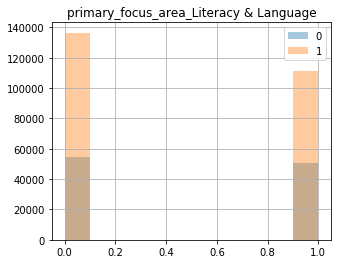

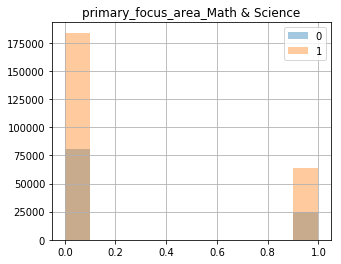

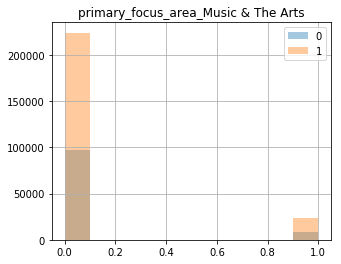

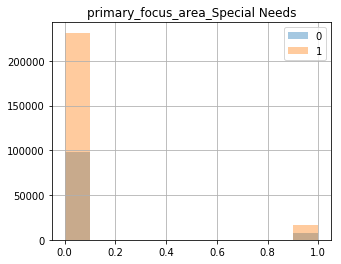

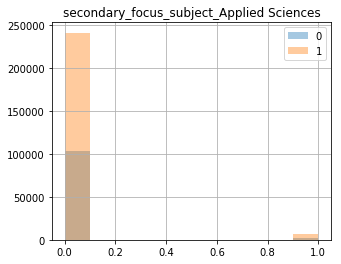

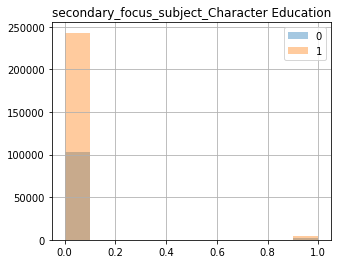

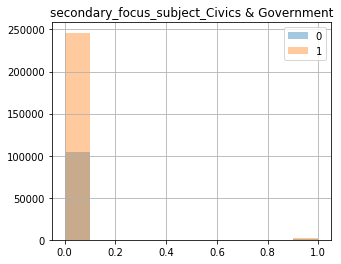

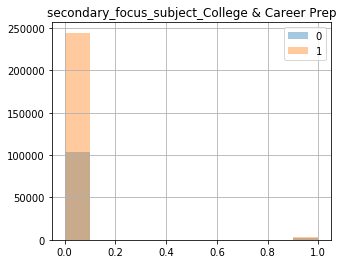

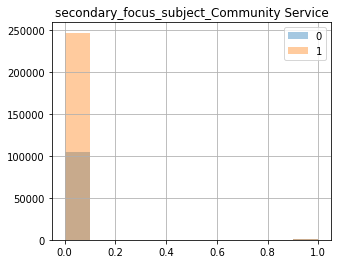

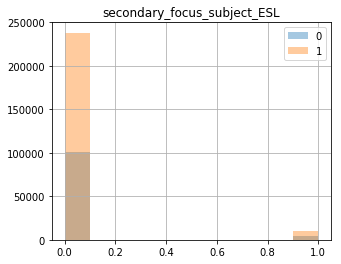

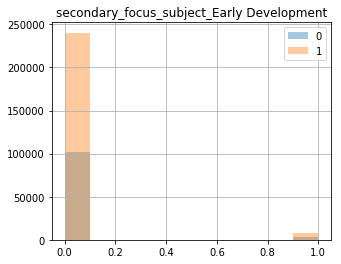

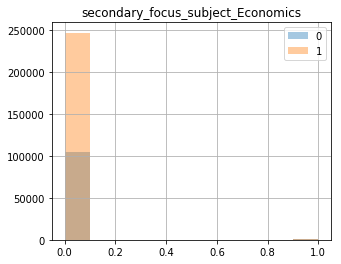

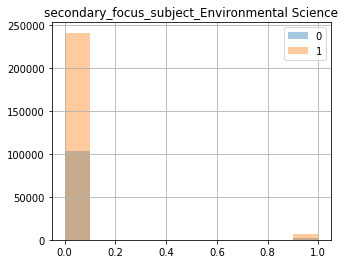

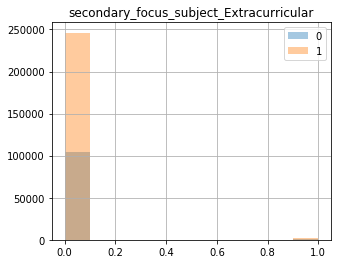

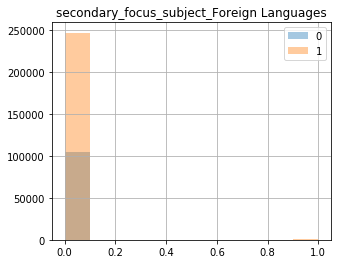

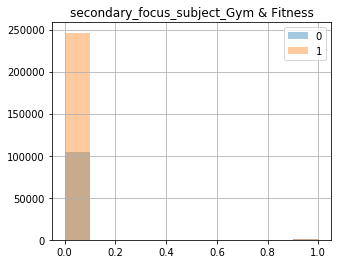

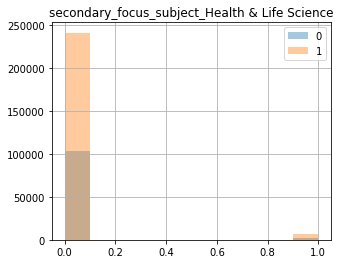

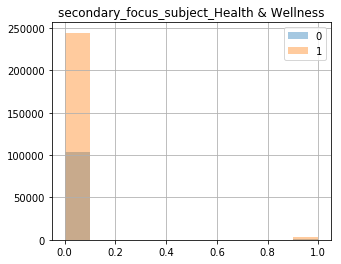

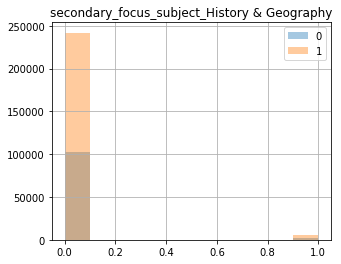

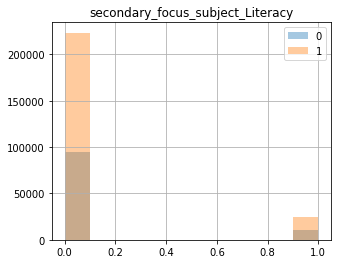

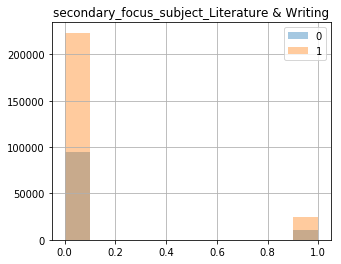

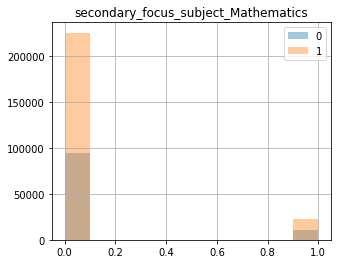

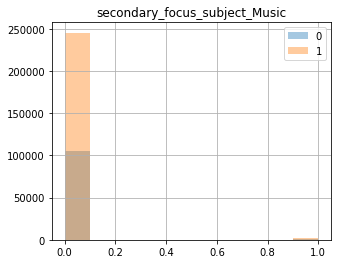

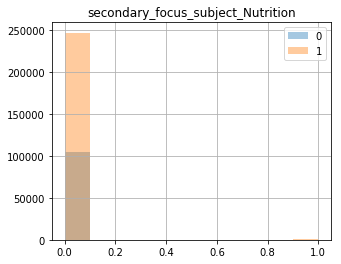

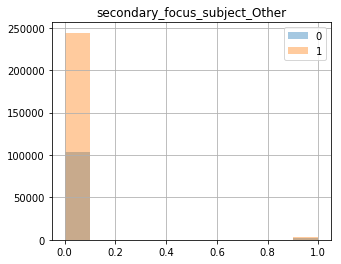

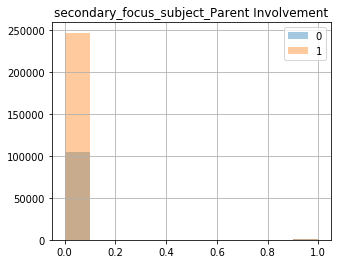

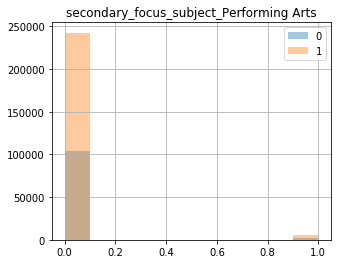

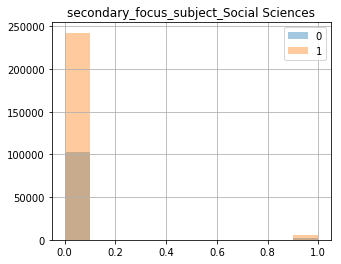

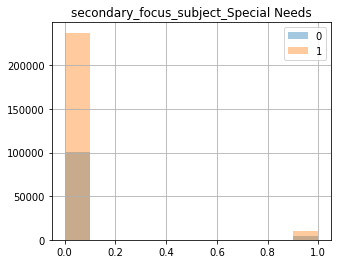

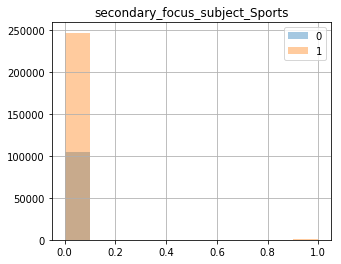

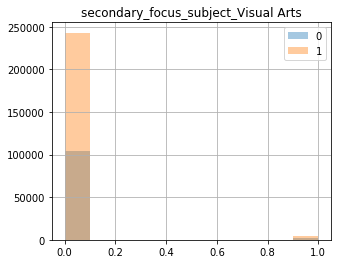

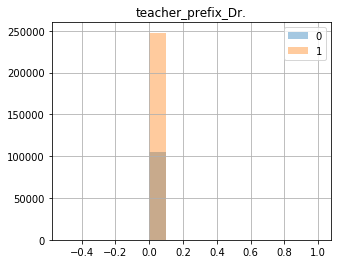

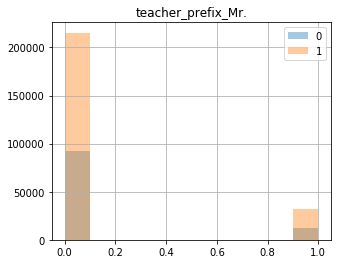

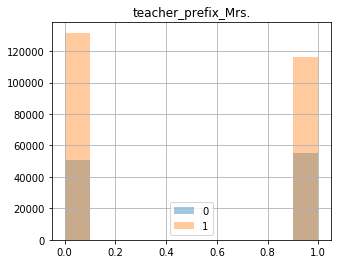

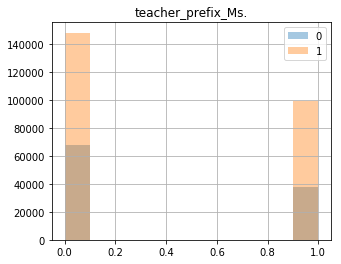

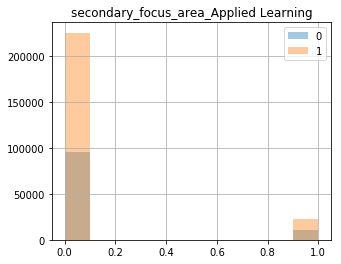

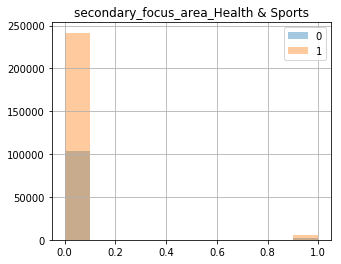

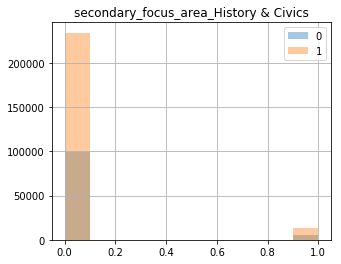

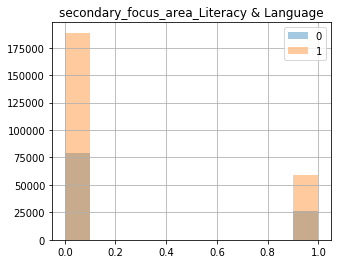

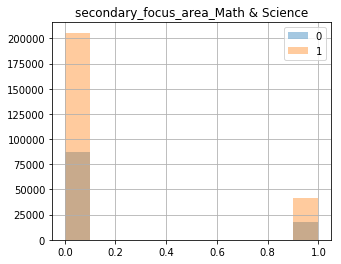

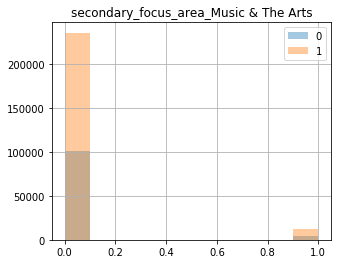

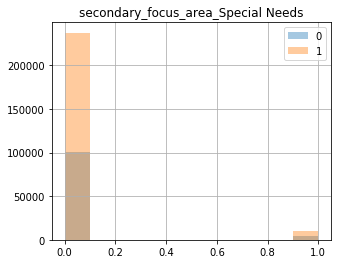

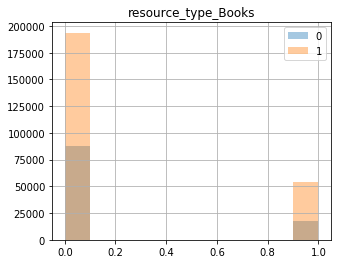

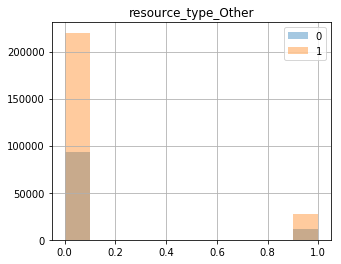

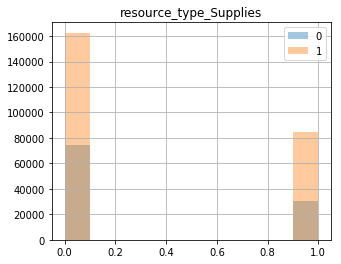

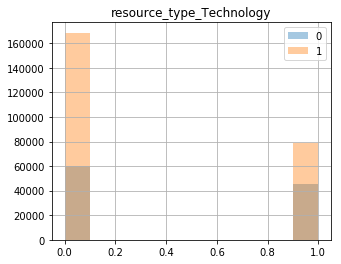

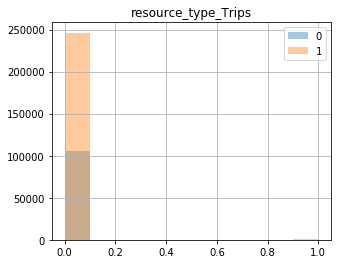

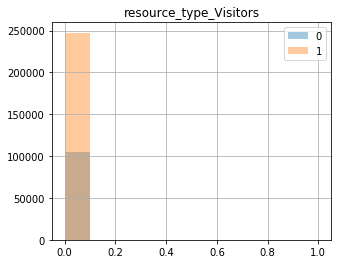

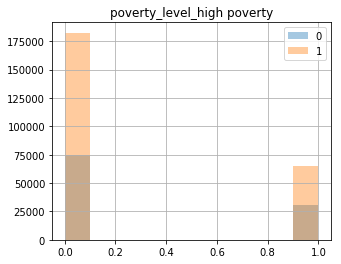

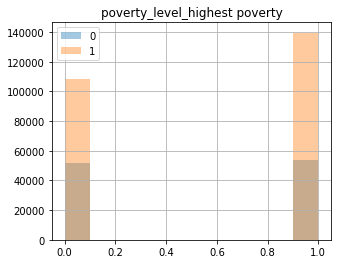

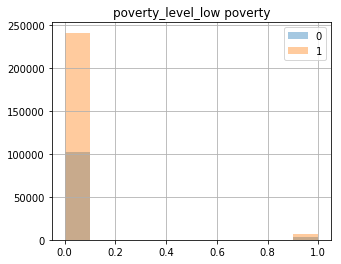

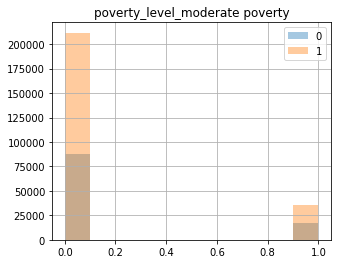

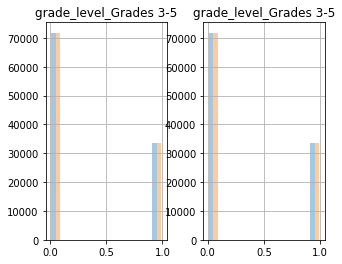

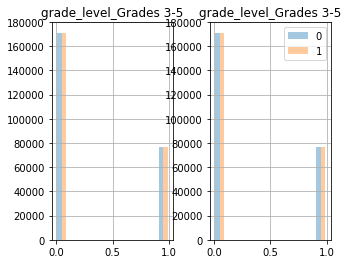

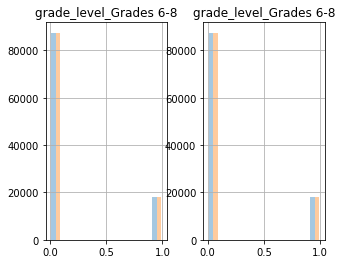

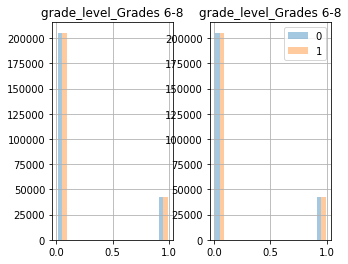

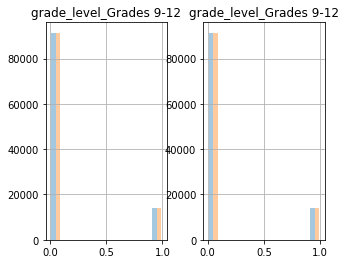

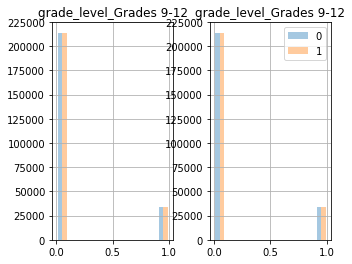

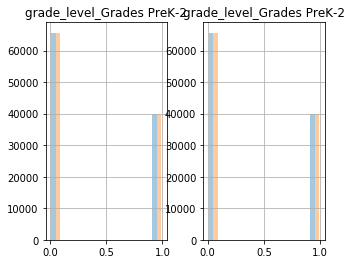

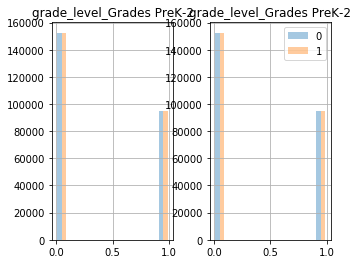

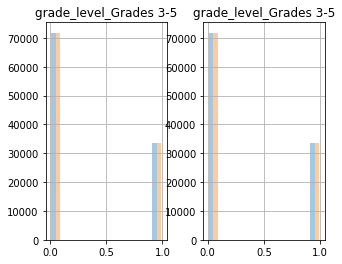

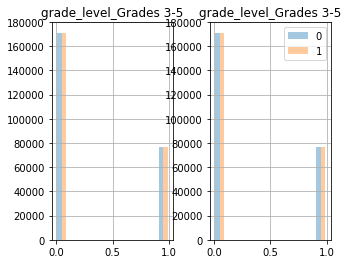

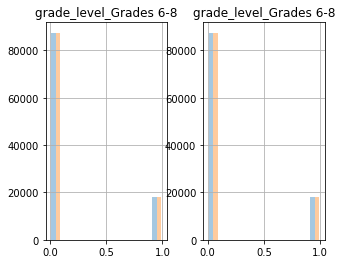

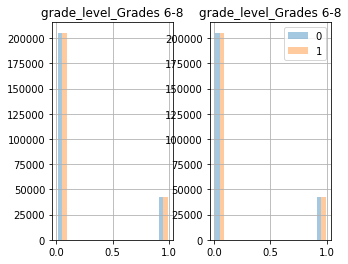

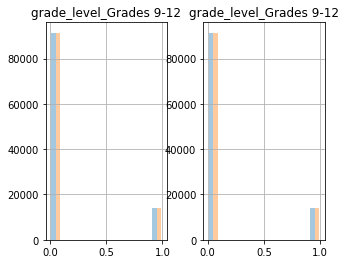

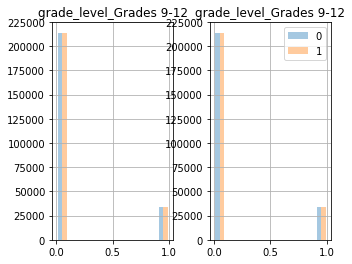

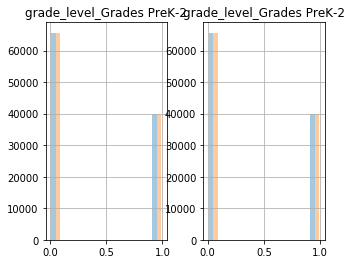

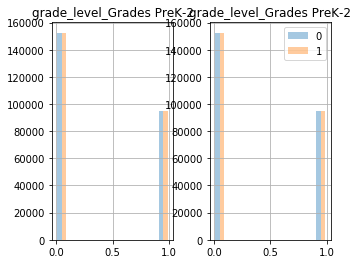

In [277]:
ex.plot_by_class(total_data, "fully_funded")

# Build and Evaluate Classifiers

In [188]:
temp_split = tm.temporal_validate('2011-01-01', '2013-12-31', [6])

In [189]:
classifiers = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
    'LR': LogisticRegression(penalty='l1', C=1e5),
    'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
    'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
    'NB': GaussianNB(),
    'DT': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier(n_neighbors=3) 
        }

parameters = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }

test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}}

In [190]:
models_to_run = ['KNN', 'LR', 'DT']

In [279]:
tm.run_models(models_to_run, classifiers, test_grid, total_data, 'fully_funded', temp_split, 'date_posted')

4.0
5.0
Running through model KNN...
{'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
hi


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').